In [104]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, confusion_matrix
from sklearn import tree
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from math import sqrt


import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import requests
import graphviz
import json
import csv
import io

# Constants
CASES_URL = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv'
DEATHS_URL = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_deaths_usafacts.csv'
POPS_URL = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv'

## Preproccessing, load the data, etc.

In [105]:
# get_dataframes -> (DataFrame, DataFrame, DataFrame)
# reads the cases, deaths, and populations json files in and converts them to pandas dataframes.
def get_dataframes():
    cases_df = ''
    deaths_df = ''
    pops_df = ''

    with open('cases.json') as file:
        cases_data = json.load(file)
        cases_df = pd.DataFrame(cases_data).transpose()
    
    with open('deaths.json') as file:
        deaths_data = json.load(file)
        deaths_df = pd.DataFrame(deaths_data).transpose()
        
    with open('pops.json') as file:
        pops_data = json.load(file)
        pops_df = pd.DataFrame(pops_data).transpose()
        
    return (cases_df, deaths_df, pops_df)
        
    
cases_df, deaths_df, pops_df = get_dataframes()
cases_df = cases_df.rename(columns={ cases_df.columns[0]: 'CountyFIPS' })
deaths_df = deaths_df.rename(columns={ deaths_df.columns[0]: 'CountyFIPS' })
pops_df = pops_df.rename(columns={ pops_df.columns[0]: 'CountyFIPS' })

# new_cases -> DataFrame
# Calculates the number of new cases in a given day based on the previous day's value and replaces the corresponding
# cell with that value.
def new_cases():
    df = cases_df.copy()
    ignored_columns = [0, 1, 2, 3, 4]
    num_cols = len(df.columns)
    
    for index, row in df.iterrows():
        for col_idx in reversed(range(num_cols)):
            if col_idx not in ignored_columns:
                curr_col = df.columns[col_idx]
                last_col = df.columns[col_idx-1]
                df.at[index, curr_col] = int(df.at[index, curr_col]) - int(df.at[index, last_col])
                
    return df

new_cases_df = new_cases()

# new_deaths -> DataFrame
# Calculates the number of new deaths in a given day based on the previous day's value and replaces the corresponding
# cell with that value.
def new_deaths():
    df = deaths_df.copy()
    ignored_columns = [0, 1, 2, 3, 4]
    num_cols = len(df.columns)
    
    for index, row in df.iterrows():
        for col_idx in reversed(range(num_cols)):
            if col_idx not in ignored_columns:
                curr_col = df.columns[col_idx]
                last_col = df.columns[col_idx-1]
                df.at[index, curr_col] = int(df.at[index, curr_col]) - int(df.at[index, last_col])
                
    return df

new_deaths_df = new_deaths()

In [3]:
# custom_test_train_split -> DataFrame
# This is a modification of the master_dataframe function that creates the same dataframe
# for the instances within a given state and county. This returned dataframe is used for testing
# since the master_dataframe is very large and often crashes our Jupyter notebooks.
def custom_test_train_split(state, county):
    c_df = cases_df.copy().iloc[:,:-7]
    d_df = deaths_df.copy().iloc[:,:-7]
    n_c_df = new_cases_df.copy().iloc[:,:-7]
    n_d_df = new_deaths_df.copy().iloc[:,:-7]
    
    train_dates = []
    test_dates = []
    train_counties = []
    test_counties = []
    train_populations = []
    test_populations = []
    train_total_cases = []
    test_total_cases = []
    train_new_cases = []
    test_new_cases = []
    train_total_deaths = []
    test_total_deaths = []
    train_new_deaths = []
    test_new_deaths = []
    train_num_cases_in_seven_days = []
    test_num_cases_in_seven_days = []
    ignored_columns = [0, 1, 2, 3]
    
    NE_states = ['ME', 'NH', 'VT', 'MA', 'CT', 'RI', 'NY', 'PA', 'NJ', 'DE', 'MD']
    
    row_index = 0
    for index, row in c_df.iterrows():
        if row['State'] != state and row['County Name'] != county:
            countyFIPS = c_df.at[index, c_df.columns[0]]
            if countyFIPS in pops_df['CountyFIPS']:
                population = pops_df.loc[pops_df['CountyFIPS'] == countyFIPS, 'population'].iloc[0]
            else:
                population = 0
            for col_idx in range(len(c_df.columns)):
                if col_idx not in ignored_columns:
                    date = cases_df.columns[col_idx]
                    train_dates.append(date)
                    train_counties.append(countyFIPS)
                    train_populations.append(population)
                    train_total_cases.append(c_df.iloc[int(row_index)][date])
                    train_new_cases.append(n_c_df.iloc[int(row_index)][date])
                    train_total_deaths.append(d_df.iloc[int(row_index)][date])
                    train_new_deaths.append(n_d_df.iloc[int(row_index)][date])
                    train_num_cases_in_seven_days.append(cases_df.iloc[int(row_index)][cases_df.columns[col_idx + 7]])
        elif row['State'] == state and row['County Name'] == county:
            countyFIPS = c_df.at[index, c_df.columns[0]]
            if countyFIPS in pops_df['CountyFIPS']:
                population = pops_df.loc[pops_df['CountyFIPS'] == countyFIPS, 'population'].iloc[0]
            else:
                population = 0
            for col_idx in range(len(c_df.columns)):
                if col_idx not in ignored_columns:
                    date = cases_df.columns[col_idx]
                    test_dates.append(date)
                    test_counties.append(countyFIPS)
                    test_populations.append(population)
                    test_total_cases.append(c_df.iloc[int(row_index)][date])
                    test_new_cases.append(n_c_df.iloc[int(row_index)][date])
                    test_total_deaths.append(d_df.iloc[int(row_index)][date])
                    test_new_deaths.append(n_d_df.iloc[int(row_index)][date])
                    test_num_cases_in_seven_days.append(cases_df.iloc[int(row_index)][cases_df.columns[col_idx + 7]])
        row_index += 1
        
    train_df = pd.DataFrame(list(zip(train_counties, train_populations, train_total_cases, train_new_cases, train_total_deaths, train_new_deaths, train_num_cases_in_seven_days)), 
                      index = train_dates, 
                      columns = ['CountyFIPS', 'Population', 'Total Cases', 'New Cases', 'Total Deaths', 'New Deaths', 'Cases in 7 Days'])
    train_cols = train_df.shape[1]
    X_train = train_df.iloc[:,0:train_cols-1]
    Y_train = train_df.iloc[:,train_cols-1:train_cols]
    
    test_df = pd.DataFrame(list(zip(test_counties, test_populations, test_total_cases, test_new_cases, test_total_deaths, test_new_deaths, test_num_cases_in_seven_days)), 
                      index = test_dates, 
                      columns = ['CountyFIPS', 'Population', 'Total Cases', 'New Cases', 'Total Deaths', 'New Deaths', 'Cases in 7 Days'])
    test_cols = test_df.shape[1]
    X_test = test_df.iloc[:,0:test_cols-1]
    Y_test = test_df.iloc[:,test_cols-1:test_cols]
    
    
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = custom_test_train_split('NY', 'Suffolk County')

In [ ]:
# custom_test_train_split -> DataFrame
# This is a modification of the master_dataframe function that creates the same dataframe
# for the instances within a given state and county. This returned dataframe is used for testing
# since the master_dataframe is very large and often crashes our Jupyter notebooks.
def custom_test_train_split():
    c_df = cases_df.copy().iloc[:,:-7]
    d_df = deaths_df.copy().iloc[:,:-7]
    n_c_df = new_cases_df.copy().iloc[:,:-7]
    n_d_df = new_deaths_df.copy().iloc[:,:-7]
    
    train_dates = []
    test_dates = []
    train_counties = []
    test_counties = []
    train_populations = []
    test_populations = []
    train_total_cases = []
    test_total_cases = []
    train_new_cases = []
    test_new_cases = []
    train_total_deaths = []
    test_total_deaths = []
    train_new_deaths = []
    test_new_deaths = []
    train_num_cases_in_seven_days = []
    test_num_cases_in_seven_days = []
    ignored_columns = [0, 1, 2, 3]
    
    unique_fips = c_df['CountyFIPS'].unique()
    random_fips_idxs = [np.random.randint(0, len(unique_fips) - 1) for _ in range(10)]
    random_fips = [unique_fips[i] for i in random_fips_idxs]
    
    row_index = 0
    for index, row in c_df.iterrows():
        if row['CountyFIPS'] not in random_fips:
            countyFIPS = c_df.at[index, c_df.columns[0]]
            if countyFIPS in pops_df['CountyFIPS']:
                population = pops_df.loc[pops_df['CountyFIPS'] == countyFIPS, 'population'].iloc[0]
            else:
                population = 0
            for col_idx in range(len(c_df.columns)):
                if col_idx not in ignored_columns:
                    date = cases_df.columns[col_idx]
                    train_dates.append(date)
                    train_counties.append(countyFIPS)
                    train_populations.append(population)
                    train_total_cases.append(c_df.iloc[int(row_index)][date])
                    train_new_cases.append(n_c_df.iloc[int(row_index)][date])
                    train_total_deaths.append(d_df.iloc[int(row_index)][date])
                    train_new_deaths.append(n_d_df.iloc[int(row_index)][date])
                    train_num_cases_in_seven_days.append(cases_df.iloc[int(row_index)][cases_df.columns[col_idx + 7]])
        else:
            countyFIPS = c_df.at[index, c_df.columns[0]]
            if countyFIPS in pops_df['CountyFIPS']:
                population = pops_df.loc[pops_df['CountyFIPS'] == countyFIPS, 'population'].iloc[0]
            else:
                population = 0
            for col_idx in range(len(c_df.columns)):
                if col_idx not in ignored_columns:
                    date = cases_df.columns[col_idx]
                    test_dates.append(date)
                    test_counties.append(countyFIPS)
                    test_populations.append(population)
                    test_total_cases.append(c_df.iloc[int(row_index)][date])
                    test_new_cases.append(n_c_df.iloc[int(row_index)][date])
                    test_total_deaths.append(d_df.iloc[int(row_index)][date])
                    test_new_deaths.append(n_d_df.iloc[int(row_index)][date])
                    test_num_cases_in_seven_days.append(cases_df.iloc[int(row_index)][cases_df.columns[col_idx + 7]])
        row_index += 1
        
    train_df = pd.DataFrame(list(zip(train_counties, train_populations, train_total_cases, train_new_cases, train_total_deaths, train_new_deaths, train_num_cases_in_seven_days)), 
                      index = train_dates, 
                      columns = ['CountyFIPS', 'Population', 'Total Cases', 'New Cases', 'Total Deaths', 'New Deaths', 'Cases in 7 Days'])
    train_cols = train_df.shape[1]
    X_train = train_df.iloc[:,0:train_cols-1]
    Y_train = train_df.iloc[:,train_cols-1:train_cols]
    
    test_df = pd.DataFrame(list(zip(test_counties, test_populations, test_total_cases, test_new_cases, test_total_deaths, test_new_deaths, test_num_cases_in_seven_days)), 
                      index = test_dates, 
                      columns = ['CountyFIPS', 'Population', 'Total Cases', 'New Cases', 'Total Deaths', 'New Deaths', 'Cases in 7 Days'])
    test_cols = test_df.shape[1]
    X_test = test_df.iloc[:,0:test_cols-1]
    Y_test = test_df.iloc[:,test_cols-1:test_cols]
    
    
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = custom_test_train_split()

## Testing and Visualizing Decision Tree Regressor

In [130]:
def graph_predicted_vs_actual_dtr(regressor):
    regressor.fit(X_train, Y_train)
    predictions = regressor.predict(X_test)

    X = Y_test.index.values
    Y = Y_test[Y_test.columns[0]].to_numpy()
    
    pred_1, pred_2, pred_3, pred_4 = np.array_split(predictions.astype(float), 4)
    Y_1, Y_2, Y_3, Y_4 = np.array_split(Y.astype(float), 4)
    X_1, X_2, X_3, X_4 = np.array_split(X, 4)
    
    def graph_subgraph(X, Y, pred):
        Y_min = np.amin(Y)
        pred_min = np.amin(pred)
        Y_min = np.minimum(Y_min, pred_min)

        Y_max = np.amax(Y)
        pred_max = np.amax(pred)
        Y_max = np.maximum(Y_max, pred_max)

        plt.figure(figsize=(15,8))
        plt.scatter(X, Y, label='Actual')
        plt.scatter(X, pred, label='Predicted')
        plt.ylim(Y_min, Y_max)
        plt.xlabel('Date')
        plt.ylabel('Number of Cases')
        plt.xticks(X[1::20], rotation=45)
        plt.title("Predicted vs. Actual for Decision Tree Regression")
        plt.legend()
        
    graph_subgraph(X_1, Y_1, pred_1)
    graph_subgraph(X_2, Y_2, pred_2)
    graph_subgraph(X_3, Y_3, pred_3)
    graph_subgraph(X_4, Y_4, pred_4) 

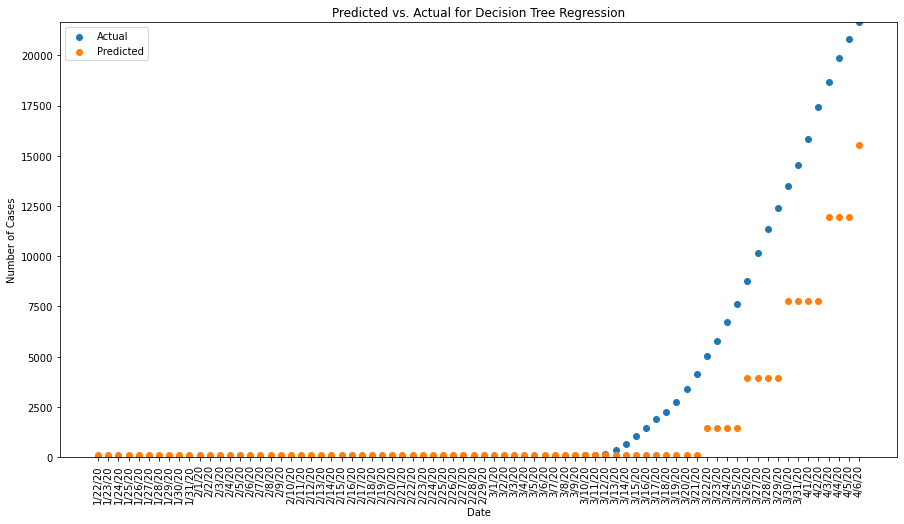

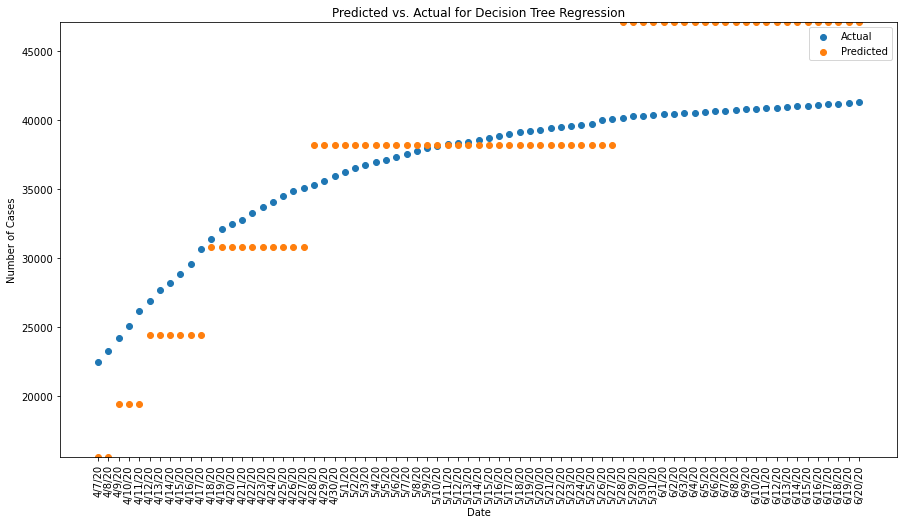

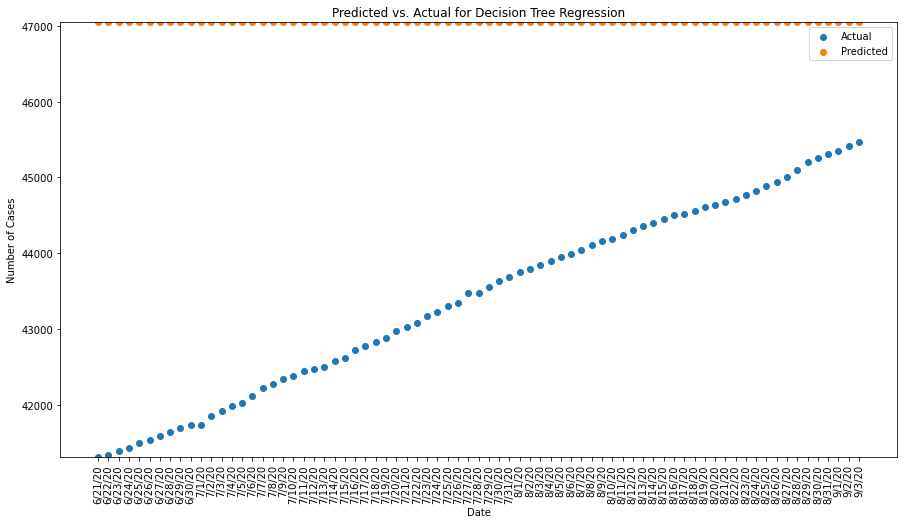

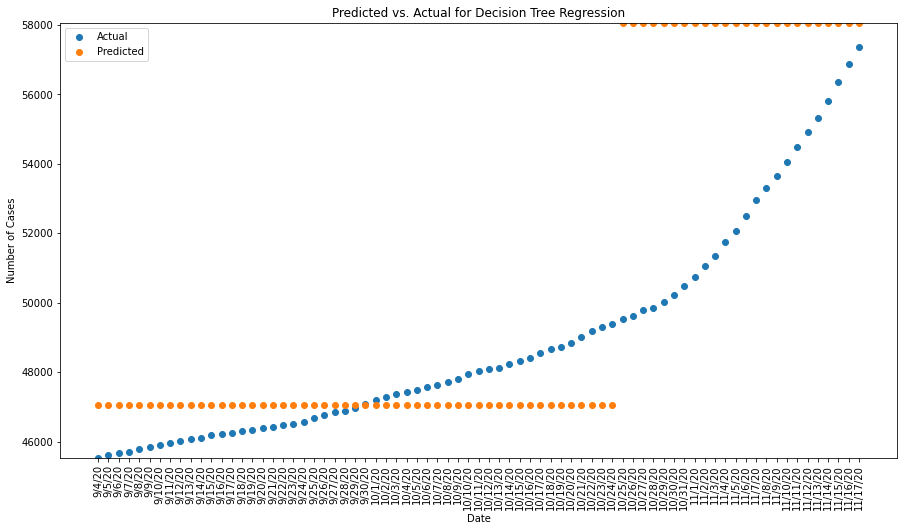

In [127]:
dtr = DecisionTreeRegressor(max_depth=5, max_leaf_nodes=20, min_samples_leaf=1, random_state=2)
graph_predicted_vs_actual_dtr(dtr)

In [94]:
dtree = DecisionTreeRegressor() # max_depth=20, min_samples_leaf=0.01, random_state=3
dtree.fit(X_train, Y_train)

grid_search_params = {
    'max_depth': [1,3,4,5,6,8,10,20,30],
    'min_samples_leaf': [.001, .01, .1, 1],
    'random_state': [1,2,3,4,5],
    'max_leaf_nodes': [5,10,15,20]
}

gridSearchCVForDecTreeReg = GridSearchCV(dtree, grid_search_params, cv = 5)
gridSearchCVForDecTreeReg.fit(X_train, Y_train)
print("best parameters are ", gridSearchCVForDecTreeReg.best_params_)

best parameters are  {'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 0.01, 'random_state': 1}


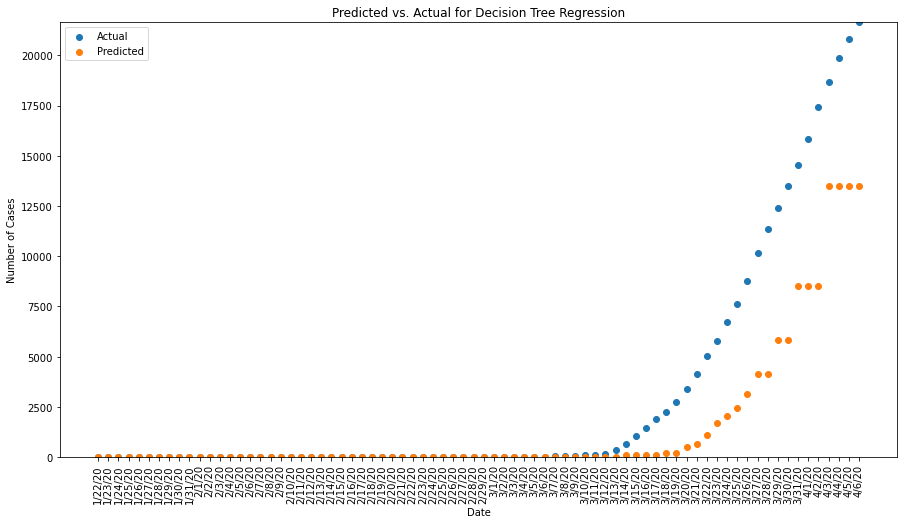

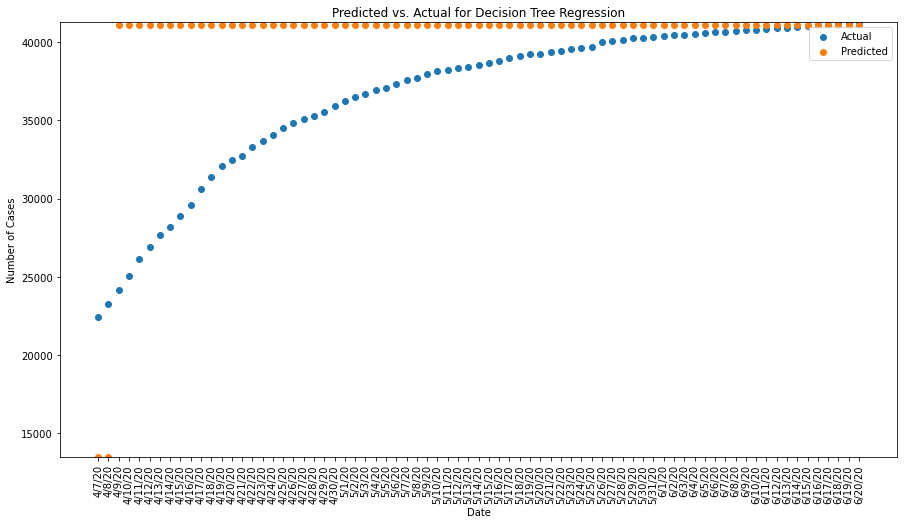

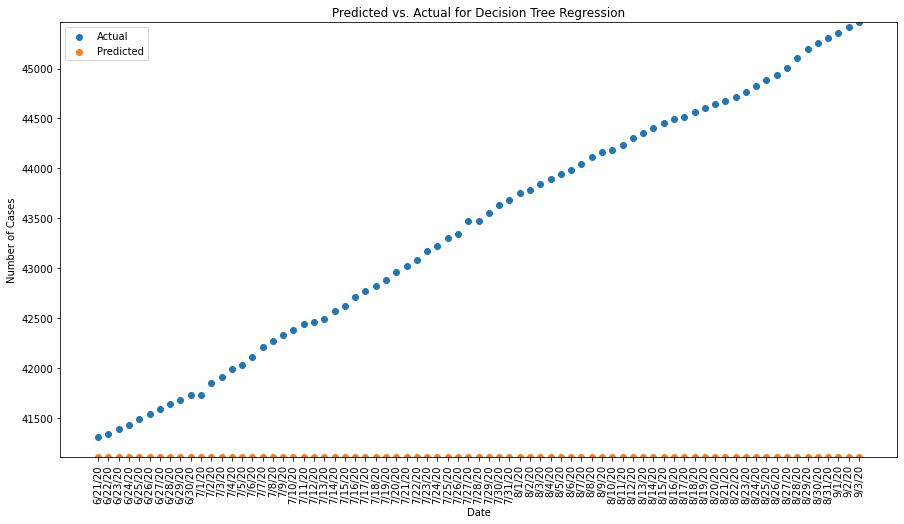

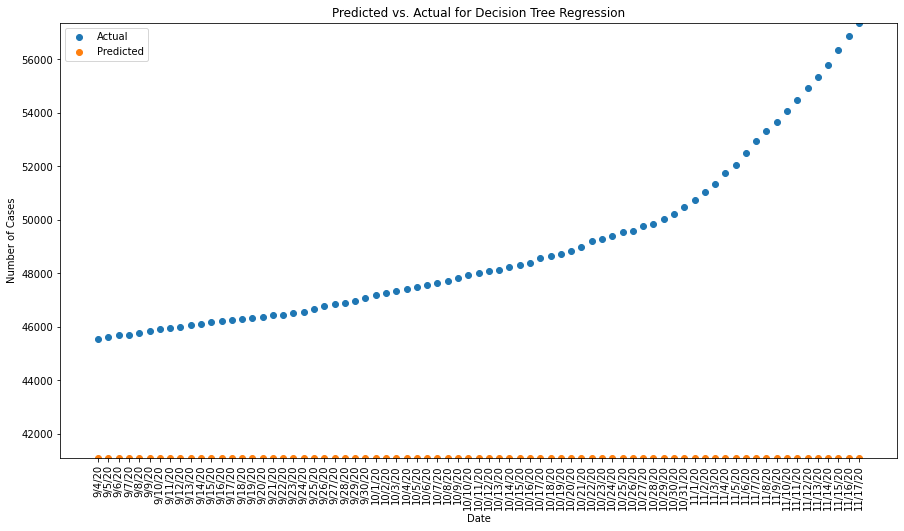

In [128]:
dtree = DecisionTreeRegressor(max_depth=6, max_leaf_nodes=20, min_samples_leaf=0.01, random_state=1) 
graph_predicted_vs_actual_dtr(dtree)

In [97]:
dtree.fit(X_train, Y_train)
pred_test_tree= dtree.predict(X_test)
print(np.sqrt(mean_squared_error(Y_test, pred_test_tree)))
print(r2_score(Y_train, pred_train_tree))

34.62785053380268
0.9901520061885448


## Testing and Visualizing Random Forest

### Graphing Predicted Vs. Actual Function for Random Forest Regressor

In [57]:
def graph_predicted_vs_actual_rfr(regressor):
    predictions = regressor.predict(X_test)

    X = Y_test.index.values
    Y = Y_test[Y_test.columns[0]].to_numpy()
    
    pred_1, pred_2, pred_3, pred_4 = np.array_split(predictions.astype(float), 4)
    Y_1, Y_2, Y_3, Y_4 = np.array_split(Y.astype(float), 4)
    X_1, X_2, X_3, X_4 = np.array_split(X, 4)
    
    def graph_subgraph(X, Y, pred):
        Y_min = np.amin(Y)
        pred_min = np.amin(pred)
        Y_min = np.minimum(Y_min, pred_min)

        Y_max = np.amax(Y)
        pred_max = np.amax(pred)
        Y_max = np.maximum(Y_max, pred_max)

        plt.figure(figsize=(15,8))
        plt.scatter(X, Y, label='Actual')
        plt.scatter(X, pred, label='Predicted')
        plt.ylim(Y_min, Y_max)
        plt.xlabel('Date')
        plt.ylabel('Number of Cases')
        plt.xticks(rotation=90)
        plt.title("Predicted vs. Actual for Decision Tree Regression")
        plt.legend()
        
    graph_subgraph(X_1, Y_1, pred_1)
    graph_subgraph(X_2, Y_2, pred_2)
    graph_subgraph(X_3, Y_3, pred_3)
    graph_subgraph(X_4, Y_4, pred_4) 

### Base example - no hyperparameter tuning

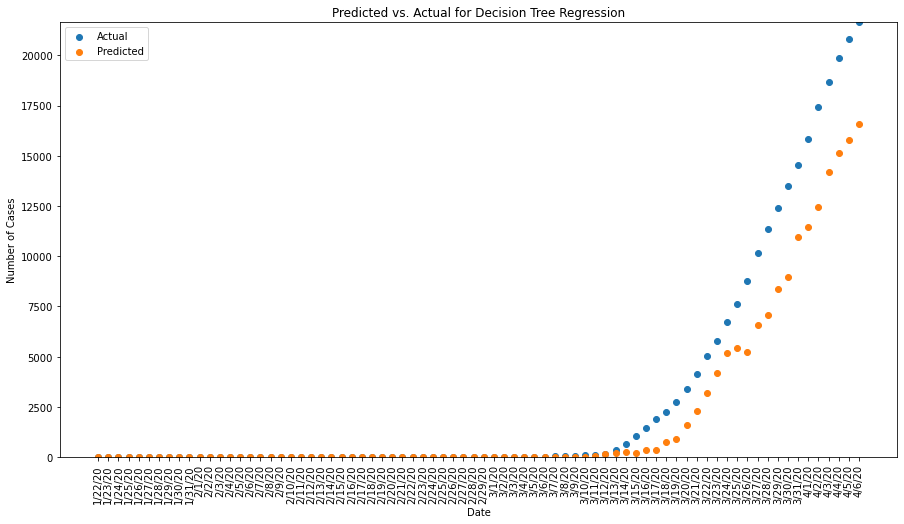

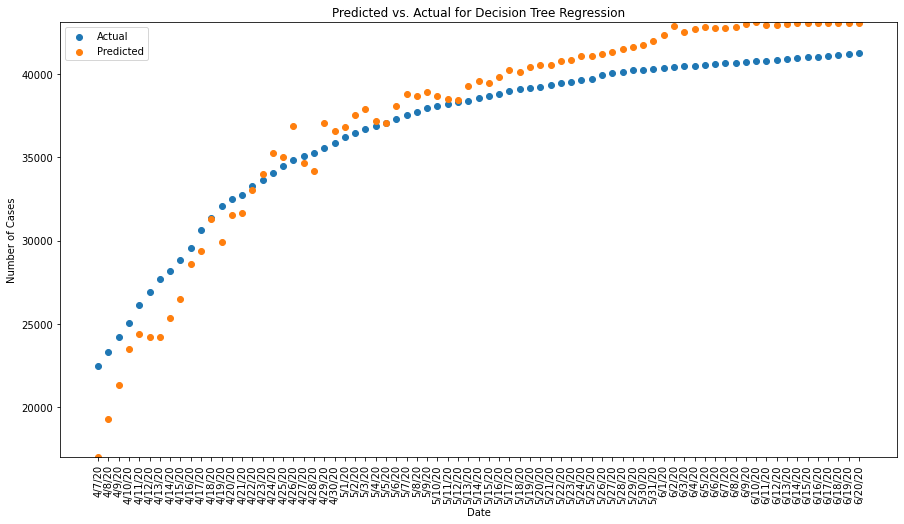

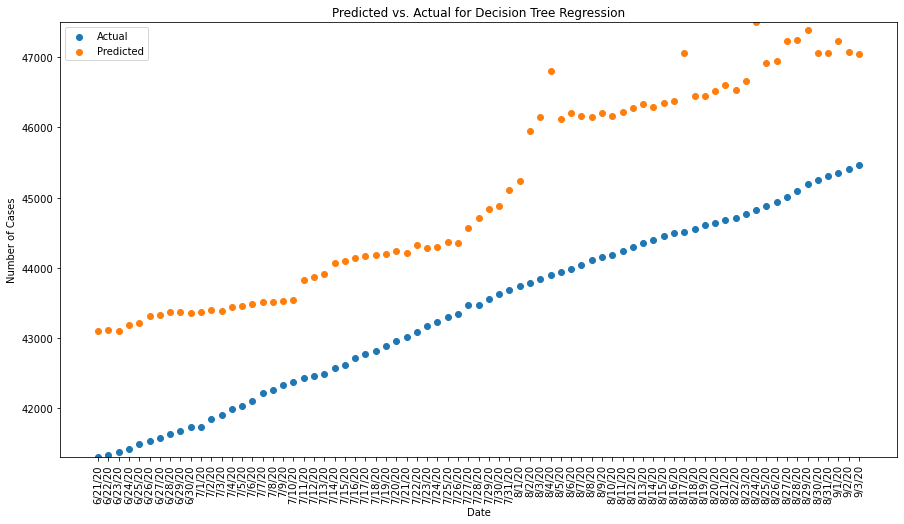

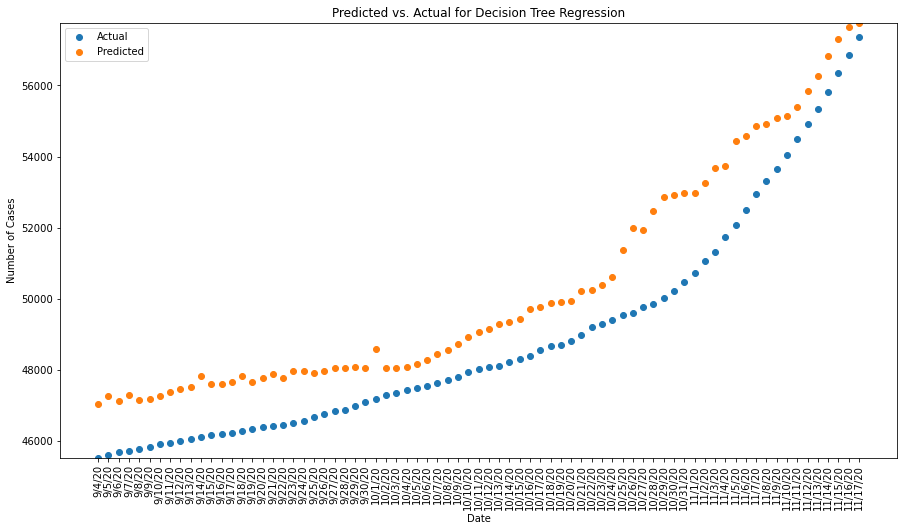

In [7]:
# Create a random forest object and fit it to our training data
rfr_base = RandomForestRegressor()
rfr_base.fit(X_train, np.ravel(Y_train))
graph_predicted_vs_actual_rfr(rfr_base)

### Random Forest Regressor hyperparameter tuning

Text(0.5, 1.0, 'n_estimator vs. R2 Score')

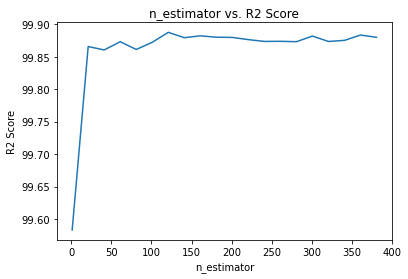

In [112]:
# Iterate through many different sizes of trees, find the optimal n_estimators
ns = []
r2_scores = []

for tree_size in range(1, 401, 20):
    rfr = RandomForestRegressor(n_estimators = tree_size)
    rfr.fit(X_train, np.ravel(Y_train))
    y_pred_rfr = rfr.predict(X_test)
    ns.append(tree_size)
    r2_scores.append(r2_score(Y_test, y_pred_rfr) * 100)
    
plt.plot(np.array(ns), np.array(r2_scores))
plt.xlabel('n_estimator')
plt.ylabel('R2 Score')
plt.title('n_estimator vs. R2 Score')

In [4]:
# Use random search to find the range of values to search around
random_grid = {'n_estimators': [int(x) for x in np.linspace(200, 2000, 100)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
               'min_samples_split': [5, 10, 20, 50, 100, 200, 500],
               'min_samples_leaf': [5, 10, 20, 50],
               'bootstrap': [True, False]}

rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=random_grid,
                               n_iter=5, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, np.ravel(Y_train))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 182.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [5, 10, 20, 50],
                                        'min_samples_split': [5, 10, 20, 50,
                                                              100, 200, 500],
                                        'n_estimators': [200, 218, 236, 254,
                                                         272, 290, 309, 327,
                                                         345, 363, 381, 400,
                                                         418, 436, 454, 472,
                                                         490, 509, 527, 545,
     

In [35]:
rf_random.best_params_

{'n_estimators': 1290,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [55]:
# Evaluate random search model by comparing to the base model
def evaluate(model, test_X, test_Y):
    np.seterr(divide='ignore', invalid='ignore')
    predictions = model.predict(test_X)
    errors = abs(predictions.astype(int) - test_Y.astype(int))
    mape = 100 * np.mean(errors / (test_Y.astype(int) + 0.01))
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
    
base_accuracy = evaluate(rfr_base, X_test, Y_test.to_numpy().flatten().astype(float))

rfr_random = rf_random.best_estimator_
random_accuracy = evaluate(rfr_random, X_test, Y_test.to_numpy().flatten().astype(float))

print('Improvement of {:0.2f}%.'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 13.9219 degrees.
Accuracy = 93.07%.
Model Performance
Average Error: 44.5346 degrees.
Accuracy = 81.74%.
Improvement of -12.17%.


In [50]:
# CV_grid = {'n_estimators': [1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320],
#            'max_features': ['auto'],
#            'max_depth': [8, 9, 10, 11, 12],
#            'min_samples_split': [8, 9, 10, 11, 12],
#            'min_samples_leaf': [8, 9, 10, 11, 12],
#            'bootstrap': [True]}
# CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=CV_grid,
#                       cv=3, n_jobs=-1, verbose=2)
# CV_rfr.fit(X_train, np.ravel(Y_train))

test_rfr = RandomForestRegressor(n_estimators=1280, max_features='auto', 
                                 max_depth=8, min_samples_split=8, 
                                 min_samples_leaf=8, bootstrap=True)

train_1, train_2, train_3, train_4 = np.array_split(X_train, 4)
train_1_y, train_2_y, train_3_y, train_4_y = np.array_split(Y_train, 4)
test_rfr.fit(train_1, np.ravel(train_1_y))

RandomForestRegressor(max_depth=8, min_samples_leaf=8, min_samples_split=8,
                      n_estimators=1280)

In [56]:
test_accuracy = evaluate(test_rfr, X_test, Y_test.to_numpy().flatten().astype(float))

Model Performance
Average Error: 51.0611 degrees.
Accuracy = -4150.74%.


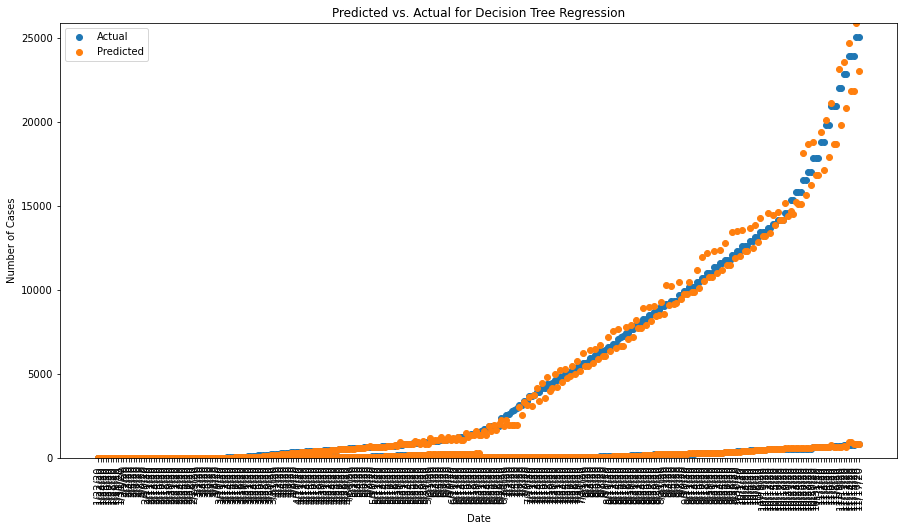

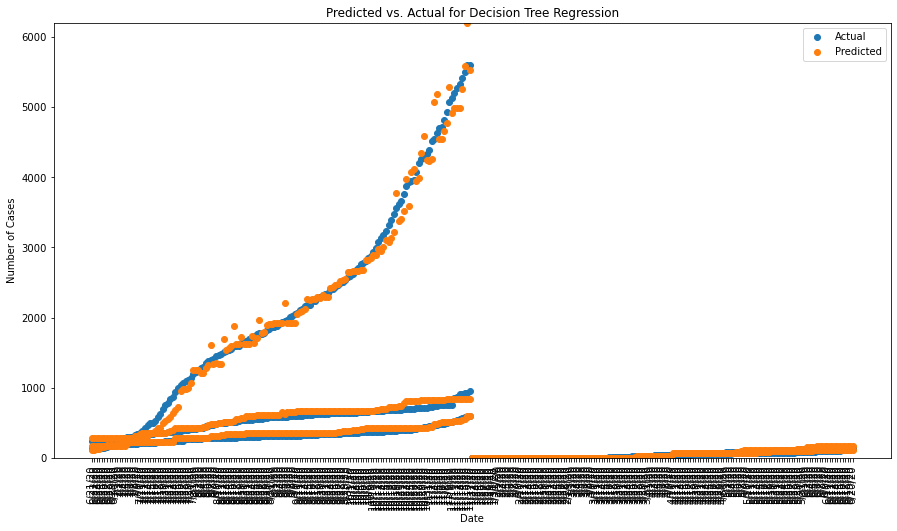

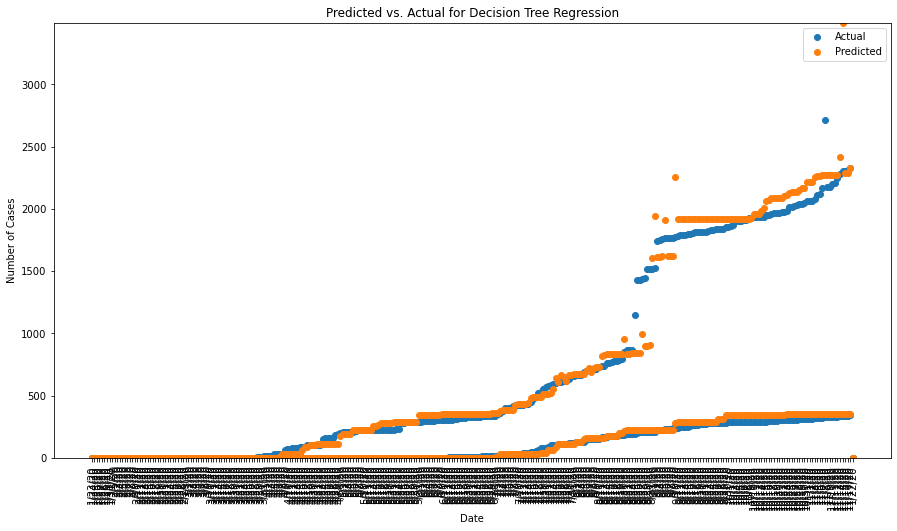

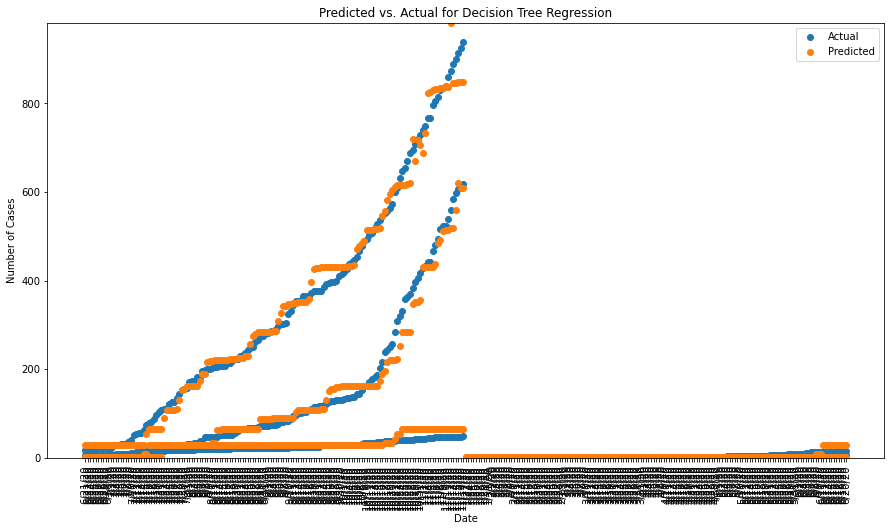

In [58]:
graph_predicted_vs_actual_rfr(test_rfr)

## Neural Network

In [97]:
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
X_test = X_test.astype('float32')
Y_test = Y_test.astype('float32')

In [98]:
normalizer = preprocessing.Normalization()

normalizer.adapt(np.array(X_train.astype(int)))
print(normalizer.mean.numpy().astype(int))

[ 30317 104363   1074     11     34      0]


In [99]:
first = np.array(X_train[:70000])

with np.printoptions(precision=2, suppress=True):
    print('First Example: ', first)
    print()
    print('Normalized: ', normalizer(first).numpy())

First Example:  [[     0.      0.      0.      0.      0.      0.]
 [     0.      0.      0.      0.      0.      0.]
 [     0.      0.      0.      0.      0.      0.]
 ...
 [  6087. 273213.    457.      2.      3.      0.]
 [  6087. 273213.    459.      2.      3.      0.]
 [  6087. 273213.    501.     42.      3.      0.]]

Normalized:  [[-2.   -0.31 -0.18 -0.17 -0.14 -0.08]
 [-2.   -0.31 -0.18 -0.17 -0.14 -0.08]
 [-2.   -0.31 -0.18 -0.17 -0.14 -0.08]
 ...
 [-1.6   0.51 -0.1  -0.14 -0.13 -0.08]
 [-1.6   0.51 -0.1  -0.14 -0.13 -0.08]
 [-1.6   0.51 -0.09  0.43 -0.13 -0.08]]


In [102]:
model = tf.keras.models.Sequential([
    normalizer,
    tf.keras.layers.Flatten(input_shape=(5,1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [103]:
history = model.fit(X_train, Y_train,
                    epochs=50,
                    verbose=2,
                    validation_split=0.2)

Epoch 1/50
23599/23599 - 18s - loss: 19134182.0000 - val_loss: 3880040.0000
Epoch 2/50


KeyboardInterrupt: 

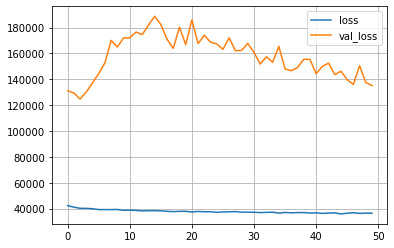

In [88]:
def plot_loss(hist):
    plt.plot(hist.history['loss'], label='loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

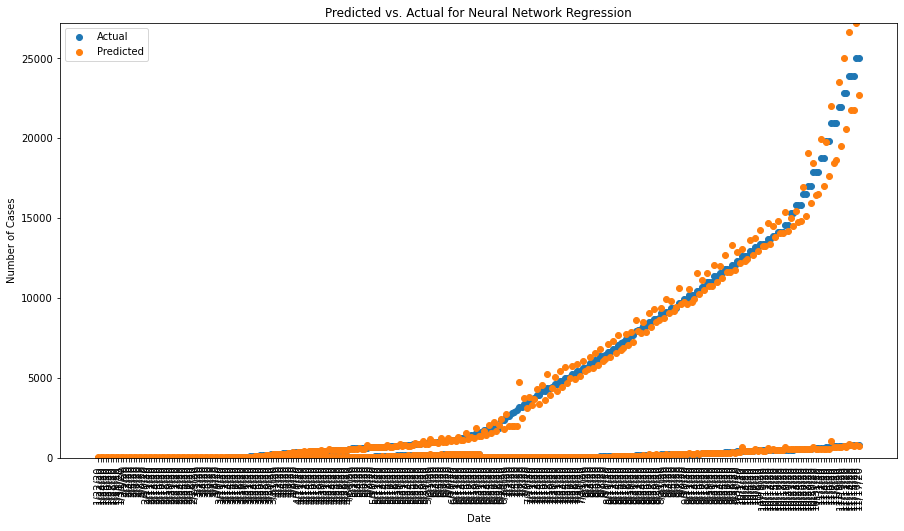

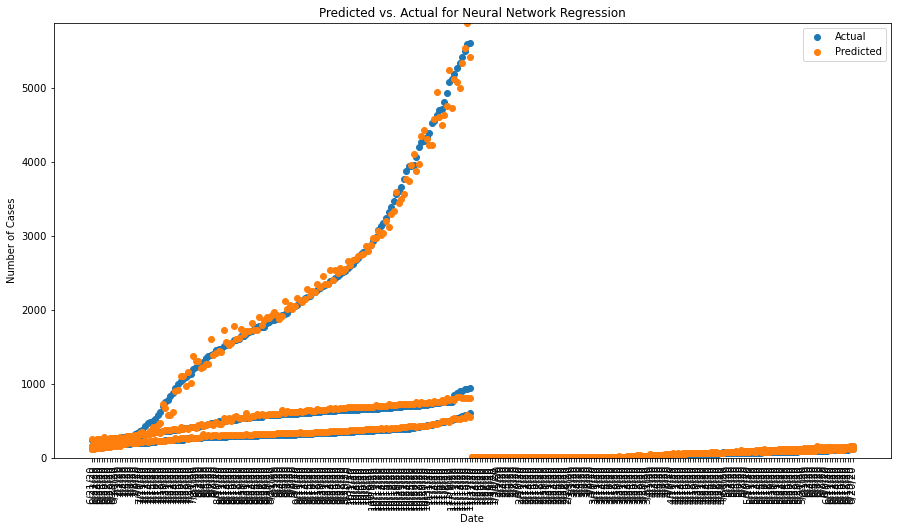

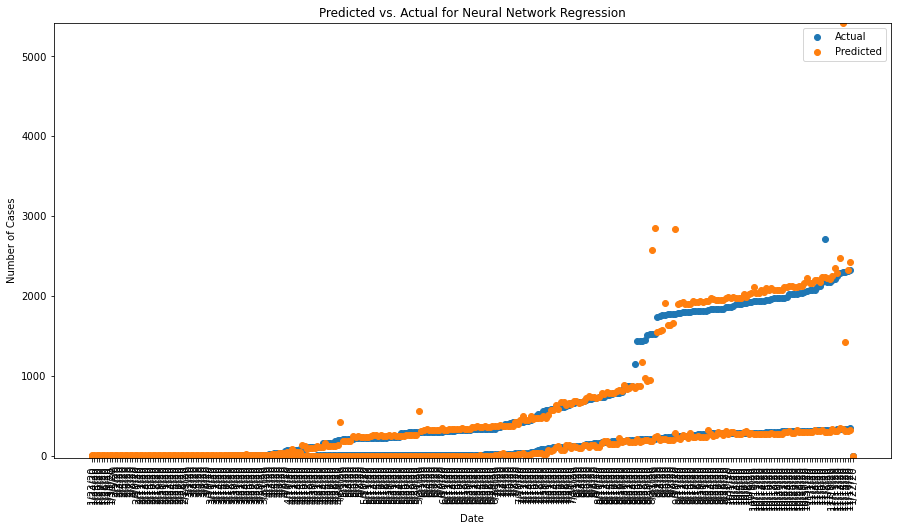

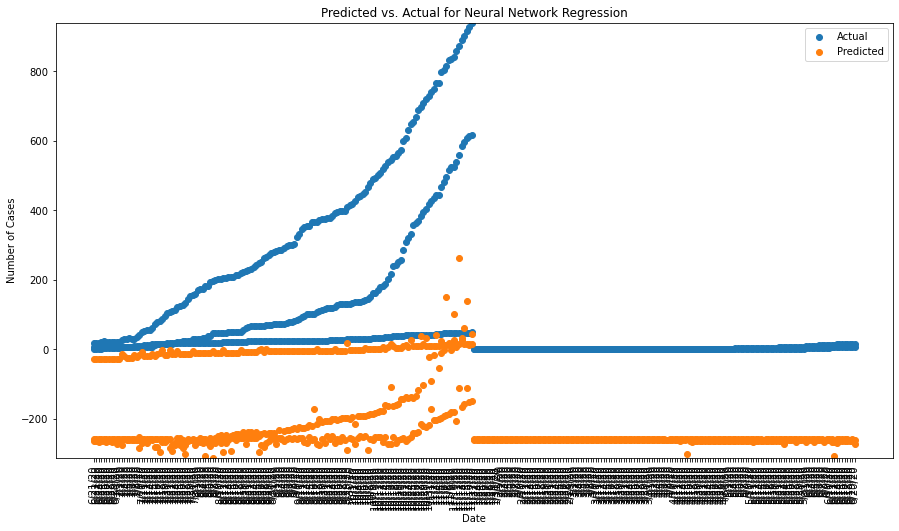

In [94]:
# x = np.asarray(x).astype('float32')
X_test = np.asarray(X_test).astype('float32')

predictions = model.predict(X_test).flatten()

def graph_predicted_vs_actual_nn():

    X = Y_test.index.values
    Y = Y_test[Y_test.columns[0]].to_numpy()
    
    pred_1, pred_2, pred_3, pred_4 = np.array_split(predictions.astype(int), 4)
    Y_1, Y_2, Y_3, Y_4 = np.array_split(Y.astype(int), 4)
    X_1, X_2, X_3, X_4 = np.array_split(X, 4)
    
    def graph_subgraph(X, Y, pred):
        Y_min = np.amin(Y)
        pred_min = np.amin(pred)
        Y_min = np.minimum(Y_min, pred_min)

        Y_max = np.amax(Y)
        pred_max = np.amax(pred)
        Y_max = np.maximum(Y_max, pred_max)

        plt.figure(figsize=(15,8))
        plt.scatter(X, Y, label='Actual')
        plt.scatter(X, pred, label='Predicted')
        plt.ylim(Y_min, Y_max)
        plt.xlabel('Date')
        plt.ylabel('Number of Cases')
        plt.xticks(rotation=90)
        plt.title("Predicted vs. Actual for Neural Network Regression")
        plt.legend()
        
    graph_subgraph(X_1, Y_1, pred_1)
    graph_subgraph(X_2, Y_2, pred_2)
    graph_subgraph(X_3, Y_3, pred_3)
    graph_subgraph(X_4, Y_4, pred_4) 
    
graph_predicted_vs_actual_nn()